# Credit Risk Analysis

### 1. The Business Problem
Problem Statement: The bank needs to minimize financial losses caused by "Non-Performing Assets" (NPAs)—loans that customers fail to repay. Currently, the manual or rule-based assessment process is inefficient, leading to two costly errors:

- High Default Rate: Approving risky customers who eventually default.

- Opportunity Cost: Rejecting creditworthy customers due to rigid, outdated rules.


Objective: Build an automated, data-driven Credit Risk Scoring Model that integrates internal customer demographics with external credit bureau (CIBIL) history to accurately predict the Probability of Default (PD).

Success Metrics:

- Primary: Maximize ROC-AUC (Area Under the Curve) to best separate "Good" vs "Bad" borrowers.

- Secondary: Maximize Recall (Catching potential defaulters is more critical than approving every good customer).

### 2. Dataset Information (The "Fuel")
We are combining two isolated data silos to create a "360-Degree Customer View."

- Dataset A: Internal Bank Data (Demographic & Stability)
- Dataset B: CIBIL / Bureau Data (Credit Behavior)

### 3. The Solution Architecture
Step 1: Exploratory Data Analysis (EDA) & Cleaning

- Import nessasary liberary

In [35]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Load datasets
- Dataset A: Internal Bank Data (Demographic & Stability)
- Dataset B: CIBIL / Bureau Data (Credit Behavior)

In [36]:
a = pd.read_excel('data/raw/case_study1.xlsx')
b = pd.read_excel('data/raw/case_study2.xlsx')

In [37]:
df1 = a.copy()
df2 = b.copy()

### Checking common column names

In [38]:
for i in list(df1.columns):
    if i in list(df2.columns):
        print (i)

PROSPECTID


### check all coloumns name and size if any error then fix it

### Merge the two dataframes, inner join so that no nulls are present

In [39]:
df = pd. merge ( df1, df2, how ='inner', left_on = ['PROSPECTID'], right_on = ['PROSPECTID'] )

In [40]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
PROSPECTID,51336.0,25668.500000,14819.571046,1.0,12834.75,25668.500,38502.25000,51336.0
Total_TL,51336.0,4.858598,7.177116,1.0,1.00,2.000,5.00000,235.0
Tot_Closed_TL,51336.0,2.770415,5.941680,0.0,0.00,1.000,3.00000,216.0
Tot_Active_TL,51336.0,2.088184,2.290774,0.0,1.00,1.000,3.00000,47.0
Total_TL_opened_L6M,51336.0,0.736754,1.296717,0.0,0.00,0.000,1.00000,27.0
...,...,...,...,...,...,...,...,...
pct_CC_enq_L6m_of_ever,51336.0,0.056302,0.213506,0.0,0.00,0.000,0.00000,1.0
max_unsec_exposure_inPct,51336.0,-45127.943635,49795.784556,-99999.0,-99999.00,0.333,2.16425,173800.0
HL_Flag,51336.0,0.271116,0.444540,0.0,0.00,0.000,1.00000,1.0
GL_Flag,51336.0,0.052887,0.223810,0.0,0.00,0.000,0.00000,1.0


### IN this data set there is no null values becouse it fills with -9999 value but check ones

In [41]:
# Check count of nulls in each column
null_counts = df.isnull().sum()
print(null_counts)

PROSPECTID             0
Total_TL               0
Tot_Closed_TL          0
Tot_Active_TL          0
Total_TL_opened_L6M    0
                      ..
GL_Flag                0
last_prod_enq2         0
first_prod_enq2        0
Credit_Score           0
Approved_Flag          0
Length: 87, dtype: int64


In [42]:
# Check percentage of nulls (Sort descending to see worst columns first)
null_pct = (df.isnull().sum() / len(df)) * 100
print(null_pct.sort_values(ascending=False))

PROSPECTID             0.0
Total_TL               0.0
Tot_Closed_TL          0.0
Tot_Active_TL          0.0
Total_TL_opened_L6M    0.0
                      ... 
GL_Flag                0.0
last_prod_enq2         0.0
first_prod_enq2        0.0
Credit_Score           0.0
Approved_Flag          0.0
Length: 87, dtype: float64


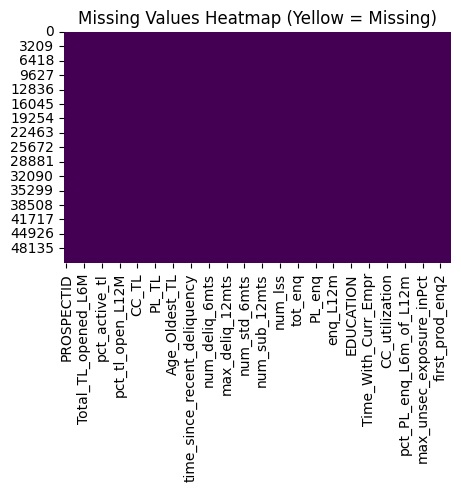

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
# cbar=False turns off the color bar to keep it clean
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap (Yellow = Missing)")
plt.show()

### here we can check null values which is fill with -9999

In [44]:
# 1. Your existing loop to find columns with -99999
columns_with_missing = []

for col in df.columns:
    if (df[col] == -99999).any():
        columns_with_missing.append(col)

# 2. Calculate Counts
counts = (df[columns_with_missing] == -99999).sum()

# 3. Calculate Percentages
# (Count / Total Rows) * 100
percentages = (counts / len(df)) * 100

# 4. Create a clean Summary DataFrame
missing_stats = pd.DataFrame({
    'Missing_Count': counts,
    'Percentage': percentages
})

# 5. Sort by Percentage (Descending) to see the worst columns first
print(missing_stats.sort_values(by='Percentage', ascending=False))

                              Missing_Count  Percentage
CC_utilization                        47636   92.792582
PL_utilization                        44435   86.557192
max_delinquency_level                 35949   70.026882
time_since_recent_deliquency          35949   70.026882
time_since_first_deliquency           35949   70.026882
max_unsec_exposure_inPct              23178   45.149603
max_deliq_6mts                        12890   25.109085
max_deliq_12mts                       10832   21.100203
PL_enq_L12m                            6321   12.312997
PL_enq                                 6321   12.312997
PL_enq_L6m                             6321   12.312997
CC_enq_L12m                            6321   12.312997
tot_enq                                6321   12.312997
CC_enq                                 6321   12.312997
CC_enq_L6m                             6321   12.312997
enq_L3m                                6321   12.312997
enq_L6m                                6321   12

### check types of data in our data set

In [45]:
num_cols = df.select_dtypes(include='number').columns.tolist()
print(num_cols)

['PROSPECTID', 'Total_TL', 'Tot_Closed_TL', 'Tot_Active_TL', 'Total_TL_opened_L6M', 'Tot_TL_closed_L6M', 'pct_tl_open_L6M', 'pct_tl_closed_L6M', 'pct_active_tl', 'pct_closed_tl', 'Total_TL_opened_L12M', 'Tot_TL_closed_L12M', 'pct_tl_open_L12M', 'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'Auto_TL', 'CC_TL', 'Consumer_TL', 'Gold_TL', 'Home_TL', 'PL_TL', 'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL', 'Age_Newest_TL', 'time_since_recent_payment', 'time_since_first_deliquency', 'time_since_recent_deliquency', 'num_times_delinquent', 'max_delinquency_level', 'max_recent_level_of_deliq', 'num_deliq_6mts', 'num_deliq_12mts', 'num_deliq_6_12mts', 'max_deliq_6mts', 'max_deliq_12mts', 'num_times_30p_dpd', 'num_times_60p_dpd', 'num_std', 'num_std_6mts', 'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt', 'num_dbt_6mts', 'num_dbt_12mts', 'num_lss', 'num_lss_6mts', 'num_lss_12mts', 'recent_level_of_deliq', 'tot_enq', 'CC_enq', 'CC_enq_L6m', 'CC_enq_L12m', 'PL_enq', 'PL_

In [46]:
# check how many columns are categorical
for i in df.columns:
    if df[i].dtype == 'object':
        print(i)

MARITALSTATUS
EDUCATION
GENDER
last_prod_enq2
first_prod_enq2
Approved_Flag


In [47]:
# check how many columns are categorical
for i in df.columns:
    if df[i].dtype != 'object':
        print(i)

PROSPECTID
Total_TL
Tot_Closed_TL
Tot_Active_TL
Total_TL_opened_L6M
Tot_TL_closed_L6M
pct_tl_open_L6M
pct_tl_closed_L6M
pct_active_tl
pct_closed_tl
Total_TL_opened_L12M
Tot_TL_closed_L12M
pct_tl_open_L12M
pct_tl_closed_L12M
Tot_Missed_Pmnt
Auto_TL
CC_TL
Consumer_TL
Gold_TL
Home_TL
PL_TL
Secured_TL
Unsecured_TL
Other_TL
Age_Oldest_TL
Age_Newest_TL
time_since_recent_payment
time_since_first_deliquency
time_since_recent_deliquency
num_times_delinquent
max_delinquency_level
max_recent_level_of_deliq
num_deliq_6mts
num_deliq_12mts
num_deliq_6_12mts
max_deliq_6mts
max_deliq_12mts
num_times_30p_dpd
num_times_60p_dpd
num_std
num_std_6mts
num_std_12mts
num_sub
num_sub_6mts
num_sub_12mts
num_dbt
num_dbt_6mts
num_dbt_12mts
num_lss
num_lss_6mts
num_lss_12mts
recent_level_of_deliq
tot_enq
CC_enq
CC_enq_L6m
CC_enq_L12m
PL_enq
PL_enq_L6m
PL_enq_L12m
time_since_recent_enq
enq_L12m
enq_L6m
enq_L3m
AGE
NETMONTHLYINCOME
Time_With_Curr_Empr
pct_of_active_TLs_ever
pct_opened_TLs_L6m_of_L12m
pct_currentBal_

In [48]:
num_cols = df.select_dtypes(include='object').columns.tolist()
print(num_cols)

['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2', 'Approved_Flag']


### if mopre then 40-90 % of data are missing in coloumns then remove that coloums


In [49]:
remove_col = ["num_lss_6mts", "num_lss_12mts", "CC_utilization" , "PL_utilization" , "max_delinquency_level" , "time_since_recent_deliquency" , "time_since_first_deliquency" , "max_unsec_exposure_inPct" ]
df = df.drop(columns=remove_col, errors='ignore')

In [50]:
df.head()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,1,5,4,1,0,0,0.000,0.0,0.200,0.800,...,0.0,0.0,0.0,0.0,1,0,PL,PL,696,P2
1,2,1,0,1,0,0,0.000,0.0,1.000,0.000,...,0.0,0.0,0.0,0.0,0,0,ConsumerLoan,ConsumerLoan,685,P2
2,3,8,0,8,1,0,0.125,0.0,1.000,0.000,...,0.0,0.0,0.0,0.0,1,0,ConsumerLoan,others,693,P2
3,4,1,0,1,1,0,1.000,0.0,1.000,0.000,...,0.0,0.0,0.0,0.0,0,0,others,others,673,P2
4,5,3,2,1,0,0,0.000,0.0,0.333,0.667,...,0.0,0.0,0.0,0.0,0,0,AL,AL,753,P1


### check skiwness of data

In [51]:
# Check skewness for all numerical columns
num_cols = df.select_dtypes(include=['number']).columns
skewness = df[num_cols].skew().sort_values(ascending=False)

print("--- Skewness of Numerical Columns ---")
print(skewness)

--- Skewness of Numerical Columns ---
num_lss                      71.504608
num_dbt_6mts                 61.209257
num_dbt_12mts                51.182907
num_sub_6mts                 47.834258
NETMONTHLYINCOME             42.199682
                               ...    
CC_enq_L6m                   -2.293954
time_since_recent_payment    -3.007787
pct_currentBal_all_TL       -26.642612
Age_Oldest_TL               -35.771724
Age_Newest_TL               -35.780395
Length: 73, dtype: float64


### less then 5% data are missing in coloumns then fill with median here because data is skewd  



In [52]:
import numpy as np

cols = ["pct_currentBal_all_TL", "Age_Oldest_TL", "Age_Newest_TL"]

df[cols] = df[cols].replace(-9999, np.nan)


In [53]:
for col in cols:
    df[col] = df[col].fillna(df[col].median())


In [54]:
"pct_currentBal_all_TL" in df.columns

True

### 5-40 % data are missing in coloumns then fill with median and imputer here because data is skewd and missing values in more hat 5 % and less then 40%


In [55]:
# Check skewness for all numerical columns
num_cols = df.select_dtypes(include=['number']).columns
skewness = df[num_cols].skew().sort_values(ascending=False)

print("--- Skewness of Numerical Columns ---")
print(skewness)

--- Skewness of Numerical Columns ---
num_lss                      71.504608
num_dbt_6mts                 61.209257
num_dbt_12mts                51.182907
num_sub_6mts                 47.834258
NETMONTHLYINCOME             42.199682
                               ...    
CC_enq_L6m                   -2.293954
time_since_recent_payment    -3.007787
pct_currentBal_all_TL       -26.642612
Age_Oldest_TL               -35.771724
Age_Newest_TL               -35.780395
Length: 73, dtype: float64


### here we can fiil the missing values with imputer and mideain

In [56]:
import numpy as np

# Keep only columns that exist in df
columns_to_process = [col for col in columns_with_missing if col in df.columns]

# Replace sentinel with NaN
df[columns_to_process] = df[columns_to_process].replace(-9999, np.nan)

# Fill NaN with column-wise median
df[columns_to_process] = df[columns_to_process].fillna(
    df[columns_to_process].median()
)


In [57]:
df.head()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,pct_PL_enq_L6m_of_L12m,pct_CC_enq_L6m_of_L12m,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,last_prod_enq2,first_prod_enq2,Credit_Score,Approved_Flag
0,1,5,4,1,0,0,0.000,0.0,0.200,0.800,...,0.0,0.0,0.0,0.0,1,0,PL,PL,696,P2
1,2,1,0,1,0,0,0.000,0.0,1.000,0.000,...,0.0,0.0,0.0,0.0,0,0,ConsumerLoan,ConsumerLoan,685,P2
2,3,8,0,8,1,0,0.125,0.0,1.000,0.000,...,0.0,0.0,0.0,0.0,1,0,ConsumerLoan,others,693,P2
3,4,1,0,1,1,0,1.000,0.0,1.000,0.000,...,0.0,0.0,0.0,0.0,0,0,others,others,673,P2
4,5,3,2,1,0,0,0.000,0.0,0.333,0.667,...,0.0,0.0,0.0,0.0,0,0,AL,AL,753,P1


Ordinal feature -- EDUCATION\
12TH           : 2\
GRADUATE       : 3\
UNDER GRADUATE : 3\
POST-GRADUATE  : 4\
OTHERS         : 1\
PROFESSIONAL   : 3

In [58]:
df.loc[df['EDUCATION'] == 'SSC',['EDUCATION']]              = 1
df.loc[df['EDUCATION'] == '12TH',['EDUCATION']]             = 2
df.loc[df['EDUCATION'] == 'GRADUATE',['EDUCATION']]         = 3
df.loc[df['EDUCATION'] == 'UNDER GRADUATE',['EDUCATION']]   = 3
df.loc[df['EDUCATION'] == 'POST-GRADUATE',['EDUCATION']]    = 4
df.loc[df['EDUCATION'] == 'OTHERS',['EDUCATION']]           = 1
df.loc[df['EDUCATION'] == 'PROFESSIONAL',['EDUCATION']]     = 3


In [59]:
df['EDUCATION'].value_counts()

EDUCATION
3    22434
2    14467
1    12193
4     2242
Name: count, dtype: int64

In [60]:
df['EDUCATION'] = df['EDUCATION'].astype(int)

In [61]:
df_encoded = pd.get_dummies(df, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'], drop_first=True)

In [62]:
df_encoded.head()

,PROSPECTID,Total_TL,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,...,last_prod_enq2_CC,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others
0,1,5,4,1,0,0,0.000,0.0,0.200,0.800,...,False,False,False,True,False,False,False,False,True,False
1,2,1,0,1,0,0,0.000,0.0,1.000,0.000,...,False,True,False,False,False,False,True,False,False,False
2,3,8,0,8,1,0,0.125,0.0,1.000,0.000,...,False,True,False,False,False,False,False,False,False,True
3,4,1,0,1,1,0,1.000,0.0,1.000,0.000,...,False,False,False,False,True,False,False,False,False,True
4,5,3,2,1,0,0,0.000,0.0,0.333,0.667,...,False,False,False,False,False,False,False,False,False,False


In [63]:
df_encoded.shape

(51336, 87)

check multicolinearity
- cat - cat  t tset
- cat - num  chi square (<= 2)
- num - num  anova (>= 2 )

In [64]:
# Chi-square test
for i in ['MARITALSTATUS', 'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2']:
    chi2, pval, _, _ = chi2_contingency(pd.crosstab(df[i], df['Approved_Flag']))
    print(i, '---', pval)

MARITALSTATUS --- 2.7588304433709322e-257
EDUCATION --- 1.6369975452615606e-34
GENDER --- 0.0002450667989541709
last_prod_enq2 --- 0.0
first_prod_enq2 --- 0.0


In [65]:
"Total_TL" in df_encoded.columns

True

In [66]:
"PL_enq_missing" in df_encoded.columns

False

### Since all the categorical features have pval <=0.05, we will accept all

In [67]:
df_encoded = df_encoded.drop(columns=["Total_TL"])

In [68]:
"Total_TL" in df_encoded.columns

False

In [69]:
missing_cols = [c for c in df_encoded.columns if c.endswith("_missing")]

In [70]:
df_encoded = df_encoded.drop(columns=missing_cols)

In [71]:
"last_prod_enq2_CC" in df_encoded.columns

True

In [72]:
df_encoded

,PROSPECTID,Tot_Closed_TL,Tot_Active_TL,Total_TL_opened_L6M,Tot_TL_closed_L6M,pct_tl_open_L6M,pct_tl_closed_L6M,pct_active_tl,pct_closed_tl,Total_TL_opened_L12M,...,last_prod_enq2_CC,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others
0,1,4,1,0,0,0.000,0.00,0.200,0.800,0,...,False,False,False,True,False,False,False,False,True,False
1,2,0,1,0,0,0.000,0.00,1.000,0.000,1,...,False,True,False,False,False,False,True,False,False,False
2,3,0,8,1,0,0.125,0.00,1.000,0.000,2,...,False,True,False,False,False,False,False,False,False,True
3,4,0,1,1,0,1.000,0.00,1.000,0.000,1,...,False,False,False,False,True,False,False,False,False,True
4,5,2,1,0,0,0.000,0.00,0.333,0.667,0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51331,51332,0,3,1,0,0.333,0.00,1.000,0.000,1,...,False,True,False,False,False,False,True,False,False,False
51332,51333,2,2,0,1,0.000,0.25,0.500,0.500,2,...,False,False,False,False,True,False,False,False,False,True
51333,51334,1,1,1,1,0.500,0.50,0.500,0.500,2,...,False,True,False,False,False,False,False,False,False,True
51334,51335,1,1,0,0,0.000,0.00,0.500,0.500,1,...,False,True,False,False,False,False,False,False,False,True


In [73]:
df_encoded = df_encoded.select_dtypes(include="number")


In [74]:
bool_cols = df_encoded.select_dtypes(include="bool").columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)


In [75]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51336 entries, 0 to 51335
Data columns (total 73 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   PROSPECTID                  51336 non-null  int64  
 1   Tot_Closed_TL               51336 non-null  int64  
 2   Tot_Active_TL               51336 non-null  int64  
 3   Total_TL_opened_L6M         51336 non-null  int64  
 4   Tot_TL_closed_L6M           51336 non-null  int64  
 5   pct_tl_open_L6M             51336 non-null  float64
 6   pct_tl_closed_L6M           51336 non-null  float64
 7   pct_active_tl               51336 non-null  float64
 8   pct_closed_tl               51336 non-null  float64
 9   Total_TL_opened_L12M        51336 non-null  int64  
 10  Tot_TL_closed_L12M          51336 non-null  int64  
 11  pct_tl_open_L12M            51336 non-null  float64
 12  pct_tl_closed_L12M          51336 non-null  float64
 13  Tot_Missed_Pmnt             513

In [76]:
# VIF for numerical columns
numeric_columns = []
# Iterate through the columns of df_encoded
for col in df_encoded.columns:
    # Use pd.api.types.is_numeric_dtype for a robust check for numeric columns
    if pd.api.types.is_numeric_dtype(df_encoded[col]) and col not in ['PROSPECTID','Approved_Flag']:
        numeric_columns.append(col)

In [77]:
# VIF sequentially check

vif_data = df_encoded[numeric_columns]
total_columns = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0

In [78]:
for i in range (0,total_columns):

    vif_value = variance_inflation_factor(vif_data.values, i)
    print (i,'---',vif_value)

    if vif_value <= 6:
        columns_to_be_kept.append( numeric_columns[i] )
        column_index = column_index+1

    else:
        vif_data = vif_data.drop([ numeric_columns[i] ] , axis=1)



/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


0 --- inf
1 --- 8.292881761481377
2 --- 5.6655267236869475
3 --- 4.378012436652608


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


4 --- inf
5 --- 11.16919614772741
6 --- 2.926418942507379
7 --- 2.52717240144056
8 --- 1.9922598099555082


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


9 --- inf


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


10 --- inf


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


11 --- inf


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


12 --- inf


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


13 --- inf
14 --- 16407.53534515243
15 --- 7.177600465137698


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


16 --- inf


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


17 --- inf
18 --- 5.0820781798844115
19 --- 13.556507898861797
20 --- 5.783724470108126
21 --- 13.779827645601353
22 --- 1.540842259200351
23 --- 2.5427339803227964
24 --- 3.097966766764907
25 --- 2.1911263975574893
26 --- 7.296531286334985
27 --- 1.0096371672746274
28 --- 1.449932552338502
29 --- 295950964.9881355
30 --- 11199362463.309118
31 --- 2020833680.2816567
32 --- 6304842767.224357
33 --- 1535345185.0327
34 --- 1657769581.7037585
35 --- 1.4013690878266005
36 --- 1.0651984604378333
37 --- 1.2655046360621158


/home/ajais/projects/credit_card/.venv/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


38 --- inf
39 --- 1.0049773253328338
40 --- 1.4707794181393647
41 --- 2.2901118057550836
42 --- 19.74707228607105
43 --- 19.202009290150308
44 --- 1.426246087794067
45 --- 1.100478813231196
46 --- 5.003121403457627


IndexError: index 47 is out of bounds for axis 1 with size 47

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

def vif_feature_selection(X, threshold=6):
    X = X.copy()

    while True:
        vif_df = pd.DataFrame({
            "feature": X.columns,
            "VIF": [
                variance_inflation_factor(X.values, i)
                for i in range(X.shape[1])
            ]
        })

        max_vif = vif_df["VIF"].max()

        if max_vif > threshold:
            drop_feature = vif_df.sort_values(
                "VIF", ascending=False
            )["feature"].iloc[0]

            print(f"Dropping '{drop_feature}' with VIF = {max_vif:.2f}")
            X = X.drop(columns=[drop_feature])
        else:
            break

    return X, vif_df


In [ ]:
X_vif_clean, final_vif = vif_feature_selection(vif_data, threshold=6)

print(final_vif.sort_values("VIF", ascending=False))


                      feature       VIF
14  max_recent_level_of_deliq  5.361956
25      recent_level_of_deliq  4.895835
7                     Home_TL  4.397788
35                    GL_Flag  4.379938
4          pct_tl_closed_L12M  3.775131
2          Tot_TL_closed_L12M  3.374664
10               Unsecured_TL  3.301239
21              num_sub_12mts  3.101087
30                    CC_Flag  3.059432
6                       CC_TL  3.011291
3            pct_tl_open_L12M  2.957710
1           pct_tl_closed_L6M  2.899174
31                    PL_Flag  2.698260
28        Time_With_Curr_Empr  2.631791
8                       PL_TL  2.628189
20               num_sub_6mts  2.541329
27           NETMONTHLYINCOME  2.520989
9                  Secured_TL  2.405633
0             pct_tl_open_L6M  2.383799
22                    num_dbt  2.130189
23              num_dbt_12mts  2.069119
11                   Other_TL  1.983834
5             Tot_Missed_Pmnt  1.938060
34                    HL_Flag  1.857498


In [ ]:
df_encoded.dtypes

,0
PROSPECTID,int64
Total_TL,int64
Tot_Closed_TL,int64
Tot_Active_TL,int64
Total_TL_opened_L6M,int64
...,...
first_prod_enq2_CC,bool
first_prod_enq2_ConsumerLoan,bool
first_prod_enq2_HL,bool
first_prod_enq2_PL,bool


In [ ]:
X = X.drop(columns=["Total_TL"], errors='ignore')

In [ ]:
X = X.drop(columns=["PROSPECTID"], errors="ignore")


In [ ]:
missing_cols = [c for c in X.columns if c.endswith("_missing")]
X_vif = X.drop(columns=missing_cols)


In [79]:
df_encoded.to_csv('processed_data.csv', index=False)
